In [278]:
import numpy as np
import cv2
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import random
from random import shuffle
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import time
from tqdm import tqdm
from scipy.ndimage import label, generate_binary_structure

import os

from moviepy.editor import VideoFileClip
from IPython.display import HTML,display


%matplotlib inline

In [279]:
# loading the data
car_img = glob.glob('training_data/vehicles/*/*.png')
noncar_img = glob.glob('training_data/non-vehicles/*/*.png')
shuffle(car_img)
shuffle(noncar_img)

# check shape of image
check_image = mpimg.imread(car_img[0])
check_image.shape

# output
print('1. car_img_size = {}'.format(len(car_img)))
print('2. noncar_img = {}'.format(len(noncar_img)))
print('3. image_shape = {}'.format(check_image.shape))

1. car_img_size = 8792
2. noncar_img = 8968
3. image_shape = (64, 64, 3)


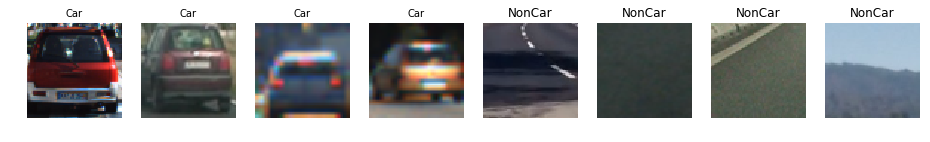

In [280]:
fig, axs = plt.subplots(1,8, figsize=(16,2))

for i in range(4):
    img = mpimg.imread(car_img[random.randint(0, len(car_img))])
    axs[i].set_title('Car', fontsize=10)
    axs[i].axis('off')
    axs[i].imshow(img)
    
for i in range(4,8):
    img = mpimg.imread(noncar_img[random.randint(0, len(noncar_img))])
    axs[i].set_title('NonCar')
    axs[i].axis('off')
    axs[i].imshow(img)

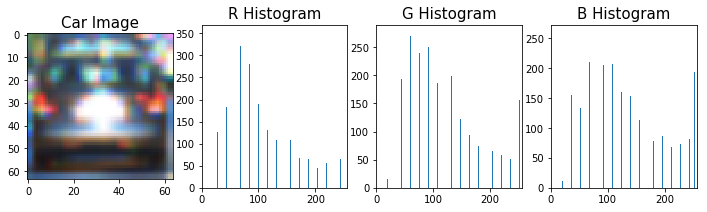

In [478]:
# Define a function to compute color histogram features
def color_hist(img, nbins=32, bins_range=(0, 256),vis=False):
    # Compute the histogram of the color channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)    
    # Generating bin centers
    bin_edges = rhist[1] 
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges) - 1])/2    
    hist_features = np.concatenate((rhist[0], bhist[0], ghist[0]))
    
    if vis == True:
        return rhist, bhist, ghist, bin_centers, hist_features
    else:
        return hist_features
    
# Read in the image
img = cv2.imread(car_img[np.random.randint(0, len(car_img))])
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Compute color histogram features of the test image
rhist, ghist, bhist, bin_centers , features= color_hist(image, nbins=32,  
                                                        bins_range=(0, 256), vis = True)

# Plot the examples
fig = plt.figure(figsize=(12,3))
plt.subplot(141)
plt.imshow(image)
plt.title('Car Image', fontsize=15)
plt.subplot(142)
plt.bar(bin_centers, rhist[0])
plt.xlim(0, 256)
plt.title('R Histogram', fontsize=15)
plt.subplot(143)
plt.bar(bin_centers, ghist[0])
plt.xlim(0, 256)
plt.title('G Histogram', fontsize=15)
plt.subplot(144)
plt.bar(bin_centers, bhist[0])
plt.xlim(0, 256)
plt.title('B Histogram', fontsize=15)

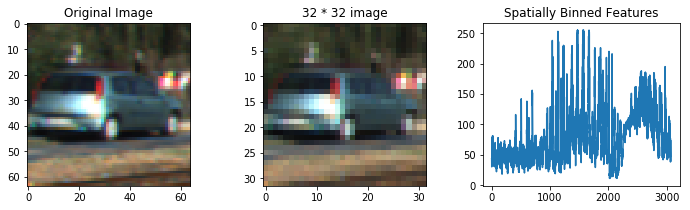

In [477]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Read in an image and run function
index = np.random.randint(0, len(car_img))
img = cv2.imread(car_img[index])
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
small_img = cv2.resize(image, (32, 32))
feature_vec = bin_spatial(image,size=(32, 32))

# Plot features
fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.imshow(image)
plt.title('Original Image')

plt.subplot(132)
plt.imshow(small_img)
plt.title('32 * 32 image')

plt.subplot(133)
plt.plot(feature_vec)
plt.title('Spatially Binned Features')

In [283]:
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    features= cv2.resize(img, size).ravel() 
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)    
    hist_features = np.concatenate((rhist[0], bhist[0], ghist[0]))
    return hist_features

def extract_features(imgs, color_space='RGB', spatial_size=(32,32), nbins=32, bins_range=(0,256)):
    # Create a list to append feature vectores to
    features = []
    for img in imgs:
        feature_image = img
        feature_image = cv2.imread(feature_image)
        feature_image = cv2.cvtColor(feature_image, cv2.COLOR_BGR2RGB)
    
        # Apply bin_spatial()
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=nbins, bins_range=bins_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
        # Return list of features vectors
    return features

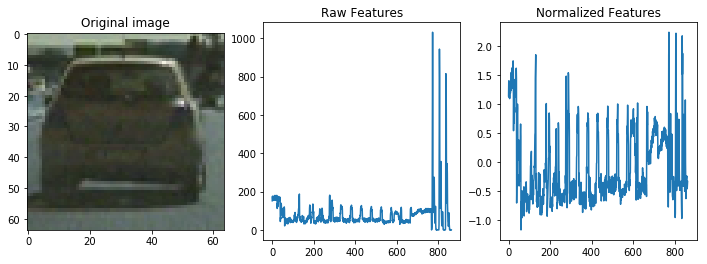

In [284]:
# Read in an image and run function
example_car = []
example_noncar = []

for i in range(50):
    index = np.random.randint(0, len(car_img))
    example_car.append(car_img[index]) # car
    example_noncar.append(noncar_img[index]) # noncar
    
car_features = extract_features(example_car,color_space='RGB', spatial_size=(16,16), nbins=32, bins_range=(0,256) )
noncar_features = extract_features(example_noncar,color_space='RGB', spatial_size=(16,16), nbins=32, bins_range=(0,256) )

# Normalize_Feautures
X =  np.vstack((car_features, noncar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
    
# Plot an example
index = np.random.randint(0, len(car_features))
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
example_car = cv2.imread(example_car[index])
plt.imshow(example_car)
plt.title('Original image')

plt.subplot(132)
plt.plot(X[index])
plt.title('Raw Features')

plt.subplot(133)
plt.plot(scaled_X[index])
plt.title('Normalized Features')

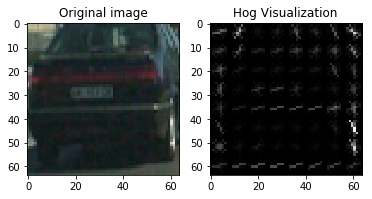

In [285]:
def get_hog_features(img,orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                      cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, visualise=True, feature_vector=False)
        return features, hog_image
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                      cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, visualise=False, feature_vector=feature_vec)
        return features
        
            
# Read in the image
img = cv2.imread(car_img[np.random.randint(0, len(car_img))])
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call functioin
features, hog_image =  get_hog_features(gray, orient, pix_per_cell, cell_per_block,  vis=True, feature_vec=False)

# Plot the image
fig = plt.figure()
plt.subplot(121)
plt.imshow(image)
plt.title('Original image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('Hog Visualization')

---------
# Start Classify training!

##   1. Define the functions

In [556]:
def bin_spatial(img, color_space='RGB', size=(16, 16)):
    features= cv2.resize(img, size).ravel() 
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)    
    hist_features = np.concatenate((rhist[0], bhist[0], ghist[0]))
    return hist_features


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=orient, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in tqdm(imgs):
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## training and test the SVM (hist & spatial & hog)

In [557]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 656] # Min and max in y to search in slide_window()

car_features = extract_features(car_img, color_space=color_space, orient=orient,  
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

noncar_features = extract_features(noncar_img, color_space=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)



# Create an array stack of feature vectors
X = np.vstack((car_features, noncar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t = time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')




  0%|          | 0/8792 [00:00<?, ?it/s]


  0%|          | 11/8792 [00:00<01:24, 103.94it/s]


  0%|          | 21/8792 [00:00<01:27, 99.72it/s] 


  0%|          | 33/8792 [00:00<01:25, 102.76it/s]


  0%|          | 43/8792 [00:00<01:26, 101.18it/s]


  1%|          | 54/8792 [00:00<01:25, 102.36it/s]


  1%|          | 64/8792 [00:00<01:26, 101.26it/s]


  1%|          | 75/8792 [00:00<01:25, 102.30it/s]


  1%|          | 86/8792 [00:00<01:23, 103.80it/s]


  1%|          | 98/8792 [00:00<01:22, 105.54it/s]


  1%|          | 109/8792 [00:01<01:25, 101.73it/s]


  1%|▏         | 119/8792 [00:01<01:26, 100.36it/s]


  1%|▏         | 130/8792 [00:01<01:24, 102.15it/s]


  2%|▏         | 141/8792 [00:01<01:26, 99.78it/s] 


  2%|▏         | 152/8792 [00:01<01:25, 100.81it/s]


  2%|▏         | 163/8792 [00:01<01:24, 102.10it/s]


  2%|▏         | 174/8792 [00:01<01:23, 103.28it/s]


  2%|▏         | 185/8792 [00:01<01:24, 101.41it/s]


  2%|▏         | 196/8792 [00:01<01:30, 95.30

 16%|█▌        | 1391/8792 [00:14<01:14, 99.23it/s]


 16%|█▌        | 1402/8792 [00:14<01:14, 99.24it/s]


 16%|█▌        | 1413/8792 [00:14<01:18, 93.72it/s]


 16%|█▌        | 1423/8792 [00:14<01:20, 91.09it/s]


 16%|█▋        | 1433/8792 [00:14<01:22, 88.68it/s]


 16%|█▋        | 1442/8792 [00:14<01:23, 87.81it/s]


 17%|█▋        | 1451/8792 [00:15<01:23, 88.25it/s]


 17%|█▋        | 1461/8792 [00:15<01:22, 89.18it/s]


 17%|█▋        | 1470/8792 [00:15<01:25, 85.80it/s]


 17%|█▋        | 1479/8792 [00:15<01:24, 86.58it/s]


 17%|█▋        | 1488/8792 [00:15<01:24, 86.78it/s]


 17%|█▋        | 1499/8792 [00:15<01:21, 89.19it/s]


 17%|█▋        | 1508/8792 [00:15<01:25, 85.04it/s]


 17%|█▋        | 1517/8792 [00:15<01:27, 83.53it/s]


 17%|█▋        | 1526/8792 [00:15<01:28, 81.88it/s]


 17%|█▋        | 1535/8792 [00:16<01:30, 80.30it/s]


 18%|█▊        | 1545/8792 [00:16<01:25, 84.54it/s]


 18%|█▊        | 1555/8792 [00:16<01:22, 88.10it/s]


 18%|█▊        | 1564/8792 [

 32%|███▏      | 2782/8792 [00:28<00:59, 101.38it/s]


 32%|███▏      | 2793/8792 [00:28<00:59, 100.95it/s]


 32%|███▏      | 2804/8792 [00:28<00:58, 103.07it/s]


 32%|███▏      | 2817/8792 [00:29<00:55, 107.58it/s]


 32%|███▏      | 2828/8792 [00:29<00:57, 102.96it/s]


 32%|███▏      | 2840/8792 [00:29<00:55, 106.46it/s]


 32%|███▏      | 2851/8792 [00:29<00:56, 104.74it/s]


 33%|███▎      | 2862/8792 [00:29<00:56, 105.48it/s]


 33%|███▎      | 2873/8792 [00:29<00:56, 105.48it/s]


 33%|███▎      | 2884/8792 [00:29<00:55, 106.20it/s]


 33%|███▎      | 2895/8792 [00:29<00:56, 105.13it/s]


 33%|███▎      | 2906/8792 [00:29<00:56, 104.03it/s]


 33%|███▎      | 2917/8792 [00:30<00:56, 104.48it/s]


 33%|███▎      | 2928/8792 [00:30<00:56, 103.42it/s]


 33%|███▎      | 2939/8792 [00:30<00:55, 105.10it/s]


 34%|███▎      | 2950/8792 [00:30<00:58, 100.02it/s]


 34%|███▎      | 2961/8792 [00:30<00:59, 97.26it/s] 


 34%|███▍      | 2972/8792 [00:30<00:59, 98.61it/s]


 34%|███▍  

 48%|████▊     | 4180/8792 [00:42<00:43, 105.07it/s]


 48%|████▊     | 4191/8792 [00:43<00:45, 100.72it/s]


 48%|████▊     | 4202/8792 [00:43<00:46, 99.72it/s] 


 48%|████▊     | 4214/8792 [00:43<00:44, 103.67it/s]


 48%|████▊     | 4226/8792 [00:43<00:42, 106.67it/s]


 48%|████▊     | 4238/8792 [00:43<00:42, 108.17it/s]


 48%|████▊     | 4249/8792 [00:43<00:42, 105.86it/s]


 48%|████▊     | 4260/8792 [00:43<00:43, 103.89it/s]


 49%|████▊     | 4272/8792 [00:43<00:42, 106.15it/s]


 49%|████▊     | 4284/8792 [00:43<00:41, 108.13it/s]


 49%|████▉     | 4296/8792 [00:43<00:41, 109.63it/s]


 49%|████▉     | 4307/8792 [00:44<00:40, 109.56it/s]


 49%|████▉     | 4318/8792 [00:44<00:41, 107.02it/s]


 49%|████▉     | 4329/8792 [00:44<00:43, 102.82it/s]


 49%|████▉     | 4340/8792 [00:44<00:44, 100.80it/s]


 49%|████▉     | 4352/8792 [00:44<00:42, 103.67it/s]


 50%|████▉     | 4363/8792 [00:44<00:43, 102.53it/s]


 50%|████▉     | 4374/8792 [00:44<00:42, 104.11it/s]


 50%|████▉

 63%|██████▎   | 5572/8792 [00:57<00:33, 96.69it/s]


 64%|██████▎   | 5584/8792 [00:57<00:31, 100.96it/s]


 64%|██████▎   | 5595/8792 [00:57<00:32, 98.46it/s] 


 64%|██████▍   | 5606/8792 [00:57<00:31, 100.17it/s]


 64%|██████▍   | 5618/8792 [00:57<00:30, 104.22it/s]


 64%|██████▍   | 5629/8792 [00:57<00:30, 103.37it/s]


 64%|██████▍   | 5640/8792 [00:57<00:30, 104.12it/s]


 64%|██████▍   | 5652/8792 [00:57<00:29, 106.73it/s]


 64%|██████▍   | 5663/8792 [00:57<00:29, 105.43it/s]


 65%|██████▍   | 5674/8792 [00:57<00:29, 105.63it/s]


 65%|██████▍   | 5685/8792 [00:58<00:29, 105.99it/s]


 65%|██████▍   | 5696/8792 [00:58<00:29, 106.45it/s]


 65%|██████▍   | 5707/8792 [00:58<00:29, 104.62it/s]


 65%|██████▌   | 5718/8792 [00:58<00:30, 101.81it/s]


 65%|██████▌   | 5729/8792 [00:58<00:29, 102.74it/s]


 65%|██████▌   | 5740/8792 [00:58<00:29, 104.68it/s]


 65%|██████▌   | 5751/8792 [00:58<00:28, 105.11it/s]


 66%|██████▌   | 5763/8792 [00:58<00:28, 107.19it/s]


 66%|██████

 80%|███████▉  | 7026/8792 [01:10<00:16, 108.38it/s]


 80%|████████  | 7038/8792 [01:11<00:15, 111.08it/s]


 80%|████████  | 7050/8792 [01:11<00:15, 113.42it/s]


 80%|████████  | 7062/8792 [01:11<00:15, 108.57it/s]


 80%|████████  | 7073/8792 [01:11<00:15, 108.06it/s]


 81%|████████  | 7085/8792 [01:11<00:15, 108.67it/s]


 81%|████████  | 7096/8792 [01:11<00:15, 106.62it/s]


 81%|████████  | 7107/8792 [01:11<00:15, 105.62it/s]


 81%|████████  | 7118/8792 [01:11<00:15, 105.98it/s]


 81%|████████  | 7129/8792 [01:11<00:17, 95.16it/s] 


 81%|████████  | 7139/8792 [01:12<00:18, 90.60it/s]


 81%|████████▏ | 7149/8792 [01:12<00:18, 89.80it/s]


 81%|████████▏ | 7160/8792 [01:12<00:17, 93.01it/s]


 82%|████████▏ | 7172/8792 [01:12<00:16, 98.28it/s]


 82%|████████▏ | 7183/8792 [01:12<00:15, 100.66it/s]


 82%|████████▏ | 7195/8792 [01:12<00:15, 104.48it/s]


 82%|████████▏ | 7206/8792 [01:12<00:16, 96.09it/s] 


 82%|████████▏ | 7216/8792 [01:12<00:16, 93.00it/s]


 82%|████████▏ 

 96%|█████████▌| 8461/8792 [01:25<00:03, 99.90it/s] 


 96%|█████████▋| 8472/8792 [01:25<00:03, 102.16it/s]


 96%|█████████▋| 8484/8792 [01:25<00:02, 104.64it/s]


 97%|█████████▋| 8496/8792 [01:25<00:02, 108.04it/s]


 97%|█████████▋| 8507/8792 [01:25<00:02, 105.33it/s]


 97%|█████████▋| 8518/8792 [01:25<00:02, 104.83it/s]


 97%|█████████▋| 8530/8792 [01:25<00:02, 108.11it/s]


 97%|█████████▋| 8541/8792 [01:25<00:02, 106.27it/s]


 97%|█████████▋| 8553/8792 [01:25<00:02, 109.00it/s]


 97%|█████████▋| 8564/8792 [01:26<00:02, 108.81it/s]


 98%|█████████▊| 8576/8792 [01:26<00:01, 109.94it/s]


 98%|█████████▊| 8588/8792 [01:26<00:01, 109.91it/s]


 98%|█████████▊| 8600/8792 [01:26<00:01, 109.58it/s]


 98%|█████████▊| 8611/8792 [01:26<00:01, 104.80it/s]


 98%|█████████▊| 8623/8792 [01:26<00:01, 107.93it/s]


 98%|█████████▊| 8634/8792 [01:26<00:01, 104.91it/s]


 98%|█████████▊| 8646/8792 [01:26<00:01, 106.36it/s]


 98%|█████████▊| 8657/8792 [01:26<00:01, 106.95it/s]


 99%|█████

 12%|█▏        | 1048/8968 [00:11<01:16, 103.63it/s]


 12%|█▏        | 1059/8968 [00:11<01:16, 103.84it/s]


 12%|█▏        | 1071/8968 [00:11<01:13, 106.84it/s]


 12%|█▏        | 1082/8968 [00:11<01:14, 105.69it/s]


 12%|█▏        | 1093/8968 [00:11<01:17, 101.55it/s]


 12%|█▏        | 1104/8968 [00:11<01:16, 102.70it/s]


 12%|█▏        | 1115/8968 [00:11<01:18, 100.61it/s]


 13%|█▎        | 1127/8968 [00:11<01:14, 105.06it/s]


 13%|█▎        | 1139/8968 [00:11<01:13, 106.50it/s]


 13%|█▎        | 1150/8968 [00:12<01:18, 99.55it/s] 


 13%|█▎        | 1161/8968 [00:12<01:17, 101.31it/s]


 13%|█▎        | 1172/8968 [00:12<01:17, 100.45it/s]


 13%|█▎        | 1184/8968 [00:12<01:15, 103.49it/s]


 13%|█▎        | 1195/8968 [00:12<01:14, 104.62it/s]


 13%|█▎        | 1206/8968 [00:12<01:15, 103.34it/s]


 14%|█▎        | 1218/8968 [00:12<01:12, 106.97it/s]


 14%|█▎        | 1229/8968 [00:12<01:15, 102.98it/s]


 14%|█▍        | 1240/8968 [00:12<01:13, 104.89it/s]


 14%|█▍   

 28%|██▊       | 2518/8968 [00:24<00:57, 111.84it/s]


 28%|██▊       | 2530/8968 [00:25<00:58, 110.45it/s]


 28%|██▊       | 2542/8968 [00:25<00:57, 111.55it/s]


 28%|██▊       | 2554/8968 [00:25<01:00, 105.56it/s]


 29%|██▊       | 2566/8968 [00:25<00:59, 108.35it/s]


 29%|██▊       | 2577/8968 [00:25<01:02, 102.14it/s]


 29%|██▉       | 2589/8968 [00:25<01:01, 104.02it/s]


 29%|██▉       | 2600/8968 [00:25<01:00, 105.66it/s]


 29%|██▉       | 2612/8968 [00:25<00:58, 107.83it/s]


 29%|██▉       | 2624/8968 [00:25<00:57, 109.63it/s]


 29%|██▉       | 2636/8968 [00:26<00:57, 111.05it/s]


 30%|██▉       | 2648/8968 [00:26<00:56, 111.76it/s]


 30%|██▉       | 2661/8968 [00:26<00:55, 114.64it/s]


 30%|██▉       | 2673/8968 [00:26<00:55, 113.90it/s]


 30%|██▉       | 2685/8968 [00:26<00:54, 114.47it/s]


 30%|███       | 2697/8968 [00:26<00:56, 110.47it/s]


 30%|███       | 2709/8968 [00:26<00:57, 109.47it/s]


 30%|███       | 2721/8968 [00:26<00:56, 110.49it/s]


 30%|███  

 45%|████▍     | 4008/8968 [00:38<00:49, 100.28it/s]


 45%|████▍     | 4019/8968 [00:39<00:51, 96.08it/s] 


 45%|████▍     | 4031/8968 [00:39<00:49, 100.41it/s]


 45%|████▌     | 4042/8968 [00:39<00:48, 102.13it/s]


 45%|████▌     | 4053/8968 [00:39<00:47, 102.53it/s]


 45%|████▌     | 4064/8968 [00:39<00:49, 98.43it/s] 


 45%|████▌     | 4074/8968 [00:39<00:50, 96.59it/s]


 46%|████▌     | 4084/8968 [00:39<00:52, 93.48it/s]


 46%|████▌     | 4095/8968 [00:39<00:50, 96.97it/s]


 46%|████▌     | 4105/8968 [00:39<00:50, 96.57it/s]


 46%|████▌     | 4115/8968 [00:40<00:50, 96.77it/s]


 46%|████▌     | 4127/8968 [00:40<00:48, 100.62it/s]


 46%|████▌     | 4139/8968 [00:40<00:46, 104.12it/s]


 46%|████▋     | 4150/8968 [00:40<00:45, 105.01it/s]


 46%|████▋     | 4161/8968 [00:40<00:45, 106.44it/s]


 47%|████▋     | 4173/8968 [00:40<00:43, 109.60it/s]


 47%|████▋     | 4186/8968 [00:40<00:42, 111.84it/s]


 47%|████▋     | 4198/8968 [00:40<00:45, 104.30it/s]


 47%|████▋     

 61%|██████▏   | 5499/8968 [00:52<00:32, 105.82it/s]


 61%|██████▏   | 5510/8968 [00:52<00:32, 106.02it/s]


 62%|██████▏   | 5522/8968 [00:52<00:32, 107.35it/s]


 62%|██████▏   | 5533/8968 [00:53<00:32, 104.44it/s]


 62%|██████▏   | 5544/8968 [00:53<00:33, 102.75it/s]


 62%|██████▏   | 5555/8968 [00:53<00:32, 103.56it/s]


 62%|██████▏   | 5566/8968 [00:53<00:32, 104.15it/s]


 62%|██████▏   | 5577/8968 [00:53<00:32, 104.95it/s]


 62%|██████▏   | 5588/8968 [00:53<00:32, 103.65it/s]


 62%|██████▏   | 5599/8968 [00:53<00:34, 97.35it/s] 


 63%|██████▎   | 5610/8968 [00:53<00:33, 100.77it/s]


 63%|██████▎   | 5621/8968 [00:53<00:32, 102.18it/s]


 63%|██████▎   | 5632/8968 [00:54<00:33, 101.07it/s]


 63%|██████▎   | 5643/8968 [00:54<00:34, 97.29it/s] 


 63%|██████▎   | 5653/8968 [00:54<00:34, 95.23it/s]


 63%|██████▎   | 5663/8968 [00:54<00:34, 94.74it/s]


 63%|██████▎   | 5674/8968 [00:54<00:33, 97.66it/s]


 63%|██████▎   | 5684/8968 [00:54<00:34, 96.36it/s]


 63%|██████▎  

 77%|███████▋  | 6914/8968 [01:06<00:21, 96.51it/s]


 77%|███████▋  | 6925/8968 [01:06<00:20, 99.13it/s]


 77%|███████▋  | 6935/8968 [01:06<00:20, 98.01it/s]


 77%|███████▋  | 6945/8968 [01:07<00:30, 67.12it/s]


 78%|███████▊  | 6954/8968 [01:07<00:29, 68.81it/s]


 78%|███████▊  | 6965/8968 [01:07<00:25, 77.25it/s]


 78%|███████▊  | 6976/8968 [01:07<00:23, 83.44it/s]


 78%|███████▊  | 6986/8968 [01:07<00:24, 80.73it/s]


 78%|███████▊  | 6995/8968 [01:07<00:23, 82.58it/s]


 78%|███████▊  | 7005/8968 [01:07<00:23, 83.96it/s]


 78%|███████▊  | 7015/8968 [01:07<00:22, 87.25it/s]


 78%|███████▊  | 7027/8968 [01:08<00:20, 93.30it/s]


 78%|███████▊  | 7038/8968 [01:08<00:19, 97.65it/s]


 79%|███████▊  | 7049/8968 [01:08<00:19, 99.74it/s]


 79%|███████▊  | 7060/8968 [01:08<00:19, 100.12it/s]


 79%|███████▉  | 7071/8968 [01:08<00:18, 100.96it/s]


 79%|███████▉  | 7082/8968 [01:08<00:18, 103.21it/s]


 79%|███████▉  | 7093/8968 [01:08<00:18, 101.77it/s]


 79%|███████▉  | 7105/89

 93%|█████████▎| 8341/8968 [01:20<00:09, 69.01it/s]


 93%|█████████▎| 8349/8968 [01:21<00:09, 68.08it/s]


 93%|█████████▎| 8357/8968 [01:21<00:10, 57.14it/s]


 93%|█████████▎| 8366/8968 [01:21<00:09, 64.16it/s]


 93%|█████████▎| 8377/8968 [01:21<00:08, 73.12it/s]


 94%|█████████▎| 8387/8968 [01:21<00:07, 78.07it/s]


 94%|█████████▎| 8396/8968 [01:21<00:07, 80.27it/s]


 94%|█████████▍| 8408/8968 [01:21<00:06, 87.78it/s]


 94%|█████████▍| 8420/8968 [01:21<00:05, 94.43it/s]


 94%|█████████▍| 8431/8968 [01:22<00:05, 96.79it/s]


 94%|█████████▍| 8443/8968 [01:22<00:05, 102.54it/s]


 94%|█████████▍| 8454/8968 [01:22<00:04, 103.44it/s]


 94%|█████████▍| 8465/8968 [01:22<00:04, 102.53it/s]


 95%|█████████▍| 8477/8968 [01:22<00:04, 105.39it/s]


 95%|█████████▍| 8488/8968 [01:22<00:06, 76.42it/s] 


 95%|█████████▍| 8499/8968 [01:22<00:05, 82.81it/s]


 95%|█████████▍| 8509/8968 [01:22<00:05, 85.97it/s]


 95%|█████████▌| 8520/8968 [01:23<00:04, 89.70it/s]


 95%|█████████▌| 8530/8

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
107.71 Seconds to train SVC...
Test Accuracy of SVC =  0.989
My SVC predicts:  [ 0.  1.  0.  0.  1.  1.  0.  1.  1.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  1.  1.  0.  1.  1.  0.]
0.14703 Seconds to predict 10 labels with SVC


## Define find_car function

In [573]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0],bbox[1], color, thick)
        #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
    # Return the image copy with boxes drawn
    return imcopy

In [574]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) -  1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) -  1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step 
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step 
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    b_boxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                b_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))                               
                
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
    return b_boxes
        

## Run find_car function

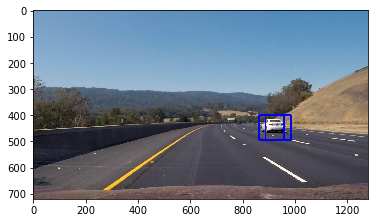

In [575]:
ystart = 400
ystop = 656
scale = 1.5
    
image = mpimg.imread('test_images/test3.jpg')
draw_image = np.copy(image)
b_boxes = find_cars(draw_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
out_img =  draw_boxes(image, b_boxes)
plt.imshow(out_img)

In [576]:
from scipy.ndimage.measurements import label
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

## Heatmap

In [577]:
from scipy.ndimage.measurements import label
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


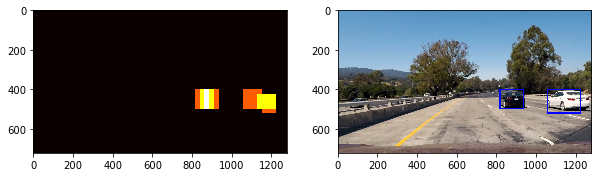

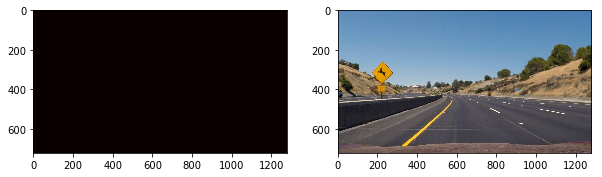

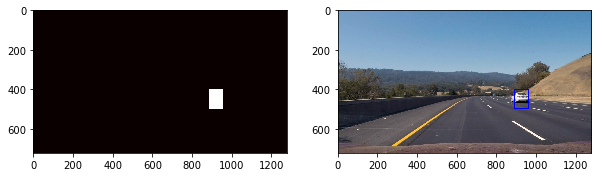

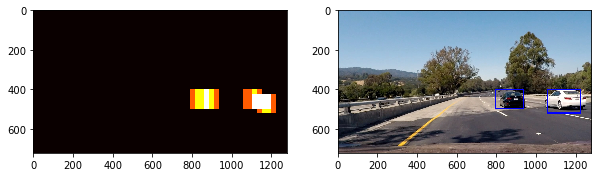

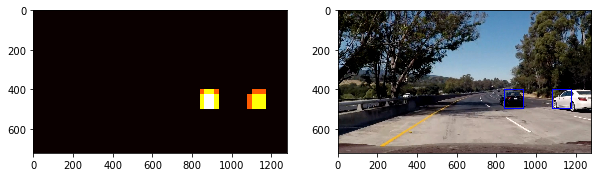

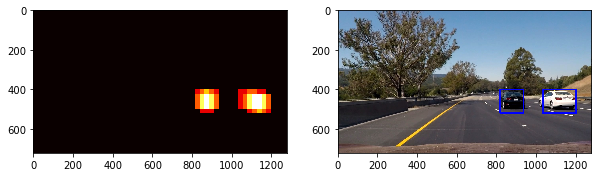

In [578]:
test_images = glob.glob('test_images/*.jpg')

for image in test_images:
    img = mpimg.imread(image)
    b_boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    add_heat(heat, b_boxes)

    heat = apply_threshold(heat,1)

    heatmap = np.clip(heat, 0, 255)

    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    plt.figure(figsize=(10,6))
    plt.subplot(121)
    plt.imshow(heat, cmap='hot')
    plt.subplot(122)
    plt.imshow(draw_img)

## Run a Video Through the Pipeline 

In [579]:
ystart = 400
ystop = 656
scale = 1.5

orient = 9
pix_per_cell = 8
cell_per_block = 2

from collections import deque
b_boxes_deque = deque(maxlen=30)

def add_heat_video(heatmap, b_boxes_deque):
    # Iterate through list of bboxes
    for bbox_list in b_boxes_deque:
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap
    
def pipeline(img):
    b_boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    b_boxes_deque.append(b_boxes)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    add_heat_video(heat, b_boxes_deque)

    heat = apply_threshold(heat,16)

    heatmap = np.clip(heat, 0, 255)

    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [580]:
from moviepy.editor import VideoFileClip

input_video = "project_video.mp4"
test_output = 'test_videos_output/project_output.mp4'

output = test_output
clip1 = VideoFileClip(input_video)
output_clip = clip1.fl_image(pipeline)
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_output.mp4
[MoviePy] Writing video test_videos_output/project_output.mp4





  0%|          | 0/1261 [00:00<?, ?it/s]


  0%|          | 1/1261 [00:00<13:05,  1.60it/s]


  0%|          | 2/1261 [00:01<12:46,  1.64it/s]


  0%|          | 3/1261 [00:01<12:19,  1.70it/s]


  0%|          | 4/1261 [00:02<11:43,  1.79it/s]


  0%|          | 5/1261 [00:02<11:52,  1.76it/s]


  0%|          | 6/1261 [00:03<11:21,  1.84it/s]


  1%|          | 7/1261 [00:03<10:43,  1.95it/s]


  1%|          | 8/1261 [00:04<10:34,  1.98it/s]


  1%|          | 9/1261 [00:04<10:06,  2.06it/s]


  1%|          | 10/1261 [00:05<09:53,  2.11it/s]


  1%|          | 11/1261 [00:05<09:29,  2.19it/s]


  1%|          | 12/1261 [00:06<09:46,  2.13it/s]


  1%|          | 13/1261 [00:06<10:10,  2.04it/s]


  1%|          | 14/1261 [00:07<09:48,  2.12it/s]


  1%|          | 15/1261 [00:07<10:09,  2.04it/s]


  1%|▏         | 16/1261 [00:08<10:17,  2.01it/s]


  1%|▏         | 17/1261 [00:08<10:14,  2.02it/s]


  1%|▏         | 18/1261 [00:09<10:25,  1.99it/s]


  2%|▏         | 19/1261 [0

 11%|█         | 134/1261 [01:07<10:08,  1.85it/s]


 11%|█         | 135/1261 [01:07<09:31,  1.97it/s]


 11%|█         | 136/1261 [01:07<08:56,  2.10it/s]


 11%|█         | 137/1261 [01:08<08:32,  2.20it/s]


 11%|█         | 138/1261 [01:08<08:25,  2.22it/s]


 11%|█         | 139/1261 [01:09<09:13,  2.03it/s]


 11%|█         | 140/1261 [01:09<09:24,  1.99it/s]


 11%|█         | 141/1261 [01:10<09:00,  2.07it/s]


 11%|█▏        | 142/1261 [01:10<08:45,  2.13it/s]


 11%|█▏        | 143/1261 [01:11<08:29,  2.19it/s]


 11%|█▏        | 144/1261 [01:11<09:00,  2.07it/s]


 11%|█▏        | 145/1261 [01:12<09:16,  2.00it/s]


 12%|█▏        | 146/1261 [01:12<08:54,  2.09it/s]


 12%|█▏        | 147/1261 [01:13<08:35,  2.16it/s]


 12%|█▏        | 148/1261 [01:13<08:17,  2.24it/s]


 12%|█▏        | 149/1261 [01:13<08:10,  2.27it/s]


 12%|█▏        | 150/1261 [01:14<07:54,  2.34it/s]


 12%|█▏        | 151/1261 [01:14<07:45,  2.39it/s]


 12%|█▏        | 152/1261 [01:15<07:38,  2.42i

 21%|██        | 266/1261 [02:06<07:02,  2.36it/s]


 21%|██        | 267/1261 [02:07<07:01,  2.36it/s]


 21%|██▏       | 268/1261 [02:07<07:00,  2.36it/s]


 21%|██▏       | 269/1261 [02:08<07:02,  2.35it/s]


 21%|██▏       | 270/1261 [02:08<07:34,  2.18it/s]


 21%|██▏       | 271/1261 [02:09<07:33,  2.18it/s]


 22%|██▏       | 272/1261 [02:09<07:31,  2.19it/s]


 22%|██▏       | 273/1261 [02:10<07:20,  2.24it/s]


 22%|██▏       | 274/1261 [02:10<07:20,  2.24it/s]


 22%|██▏       | 275/1261 [02:10<07:09,  2.30it/s]


 22%|██▏       | 276/1261 [02:11<07:18,  2.25it/s]


 22%|██▏       | 277/1261 [02:11<07:21,  2.23it/s]


 22%|██▏       | 278/1261 [02:12<07:22,  2.22it/s]


 22%|██▏       | 279/1261 [02:12<07:35,  2.16it/s]


 22%|██▏       | 280/1261 [02:13<08:29,  1.93it/s]


 22%|██▏       | 281/1261 [02:14<08:52,  1.84it/s]


 22%|██▏       | 282/1261 [02:14<08:19,  1.96it/s]


 22%|██▏       | 283/1261 [02:15<08:23,  1.94it/s]


 23%|██▎       | 284/1261 [02:15<08:56,  1.82i

 32%|███▏      | 398/1261 [03:12<06:28,  2.22it/s]


 32%|███▏      | 399/1261 [03:13<06:15,  2.29it/s]


 32%|███▏      | 400/1261 [03:13<06:09,  2.33it/s]


 32%|███▏      | 401/1261 [03:14<06:48,  2.10it/s]


 32%|███▏      | 402/1261 [03:14<06:40,  2.14it/s]


 32%|███▏      | 403/1261 [03:15<06:37,  2.16it/s]


 32%|███▏      | 404/1261 [03:15<06:28,  2.20it/s]


 32%|███▏      | 405/1261 [03:16<06:19,  2.25it/s]


 32%|███▏      | 406/1261 [03:16<06:15,  2.28it/s]


 32%|███▏      | 407/1261 [03:16<06:13,  2.29it/s]


 32%|███▏      | 408/1261 [03:17<06:06,  2.33it/s]


 32%|███▏      | 409/1261 [03:17<06:08,  2.31it/s]


 33%|███▎      | 410/1261 [03:18<06:09,  2.31it/s]


 33%|███▎      | 411/1261 [03:18<06:15,  2.26it/s]


 33%|███▎      | 412/1261 [03:19<06:11,  2.28it/s]


 33%|███▎      | 413/1261 [03:19<06:08,  2.30it/s]


 33%|███▎      | 414/1261 [03:20<06:09,  2.29it/s]


 33%|███▎      | 415/1261 [03:20<06:09,  2.29it/s]


 33%|███▎      | 416/1261 [03:20<06:12,  2.27i

 42%|████▏     | 530/1261 [04:14<05:54,  2.06it/s]


 42%|████▏     | 531/1261 [04:15<05:45,  2.11it/s]


 42%|████▏     | 532/1261 [04:15<05:50,  2.08it/s]


 42%|████▏     | 533/1261 [04:16<06:07,  1.98it/s]


 42%|████▏     | 534/1261 [04:16<05:55,  2.04it/s]


 42%|████▏     | 535/1261 [04:17<05:44,  2.11it/s]


 43%|████▎     | 536/1261 [04:17<05:46,  2.09it/s]


 43%|████▎     | 537/1261 [04:18<05:56,  2.03it/s]


 43%|████▎     | 538/1261 [04:18<05:58,  2.02it/s]


 43%|████▎     | 539/1261 [04:19<05:50,  2.06it/s]


 43%|████▎     | 540/1261 [04:19<05:49,  2.06it/s]


 43%|████▎     | 541/1261 [04:20<05:33,  2.16it/s]


 43%|████▎     | 542/1261 [04:20<05:32,  2.17it/s]


 43%|████▎     | 543/1261 [04:21<05:30,  2.17it/s]


 43%|████▎     | 544/1261 [04:21<05:35,  2.14it/s]


 43%|████▎     | 545/1261 [04:22<05:36,  2.13it/s]


 43%|████▎     | 546/1261 [04:22<05:26,  2.19it/s]


 43%|████▎     | 547/1261 [04:23<05:24,  2.20it/s]


 43%|████▎     | 548/1261 [04:23<05:22,  2.21i

 52%|█████▏    | 662/1261 [05:20<05:37,  1.78it/s]


 53%|█████▎    | 663/1261 [05:21<05:28,  1.82it/s]


 53%|█████▎    | 664/1261 [05:21<05:03,  1.97it/s]


 53%|█████▎    | 665/1261 [05:21<04:58,  2.00it/s]


 53%|█████▎    | 666/1261 [05:22<05:52,  1.69it/s]


 53%|█████▎    | 667/1261 [05:23<06:16,  1.58it/s]


 53%|█████▎    | 668/1261 [05:24<06:05,  1.62it/s]


 53%|█████▎    | 669/1261 [05:24<05:43,  1.72it/s]


 53%|█████▎    | 670/1261 [05:25<05:20,  1.85it/s]


 53%|█████▎    | 671/1261 [05:25<05:18,  1.85it/s]


 53%|█████▎    | 672/1261 [05:26<05:11,  1.89it/s]


 53%|█████▎    | 673/1261 [05:26<04:59,  1.96it/s]


 53%|█████▎    | 674/1261 [05:27<05:16,  1.86it/s]


 54%|█████▎    | 675/1261 [05:28<06:26,  1.51it/s]


 54%|█████▎    | 676/1261 [05:28<06:04,  1.61it/s]


 54%|█████▎    | 677/1261 [05:29<06:32,  1.49it/s]


 54%|█████▍    | 678/1261 [05:29<06:14,  1.56it/s]


 54%|█████▍    | 679/1261 [05:30<05:54,  1.64it/s]


 54%|█████▍    | 680/1261 [05:31<06:13,  1.55i

 63%|██████▎   | 794/1261 [06:30<04:20,  1.79it/s]


 63%|██████▎   | 795/1261 [06:31<04:14,  1.83it/s]


 63%|██████▎   | 796/1261 [06:31<04:05,  1.89it/s]


 63%|██████▎   | 797/1261 [06:32<04:02,  1.91it/s]


 63%|██████▎   | 798/1261 [06:32<03:52,  1.99it/s]


 63%|██████▎   | 799/1261 [06:33<03:47,  2.03it/s]


 63%|██████▎   | 800/1261 [06:33<03:59,  1.93it/s]


 64%|██████▎   | 801/1261 [06:34<03:54,  1.96it/s]


 64%|██████▎   | 802/1261 [06:35<04:11,  1.82it/s]


 64%|██████▎   | 803/1261 [06:35<04:17,  1.78it/s]


 64%|██████▍   | 804/1261 [06:36<04:12,  1.81it/s]


 64%|██████▍   | 805/1261 [06:36<04:08,  1.84it/s]


 64%|██████▍   | 806/1261 [06:37<03:51,  1.96it/s]


 64%|██████▍   | 807/1261 [06:37<03:44,  2.03it/s]


 64%|██████▍   | 808/1261 [06:38<03:42,  2.04it/s]


 64%|██████▍   | 809/1261 [06:38<03:42,  2.03it/s]


 64%|██████▍   | 810/1261 [06:39<03:41,  2.04it/s]


 64%|██████▍   | 811/1261 [06:39<03:43,  2.02it/s]


 64%|██████▍   | 812/1261 [06:40<03:35,  2.08i

 73%|███████▎  | 926/1261 [07:37<02:35,  2.15it/s]


 74%|███████▎  | 927/1261 [07:37<02:34,  2.16it/s]


 74%|███████▎  | 928/1261 [07:38<02:32,  2.19it/s]


 74%|███████▎  | 929/1261 [07:38<02:29,  2.21it/s]


 74%|███████▍  | 930/1261 [07:39<02:27,  2.24it/s]


 74%|███████▍  | 931/1261 [07:39<02:27,  2.24it/s]


 74%|███████▍  | 932/1261 [07:40<02:26,  2.24it/s]


 74%|███████▍  | 933/1261 [07:40<02:25,  2.26it/s]


 74%|███████▍  | 934/1261 [07:40<02:24,  2.26it/s]


 74%|███████▍  | 935/1261 [07:41<02:25,  2.24it/s]


 74%|███████▍  | 936/1261 [07:41<02:26,  2.22it/s]


 74%|███████▍  | 937/1261 [07:42<02:25,  2.23it/s]


 74%|███████▍  | 938/1261 [07:42<02:26,  2.20it/s]


 74%|███████▍  | 939/1261 [07:43<02:27,  2.19it/s]


 75%|███████▍  | 940/1261 [07:43<02:26,  2.19it/s]


 75%|███████▍  | 941/1261 [07:44<02:26,  2.19it/s]


 75%|███████▍  | 942/1261 [07:44<02:28,  2.15it/s]


 75%|███████▍  | 943/1261 [07:45<02:27,  2.16it/s]


 75%|███████▍  | 944/1261 [07:45<02:26,  2.16i

 84%|████████▍ | 1057/1261 [08:38<01:35,  2.14it/s]


 84%|████████▍ | 1058/1261 [08:39<01:33,  2.17it/s]


 84%|████████▍ | 1059/1261 [08:39<01:33,  2.15it/s]


 84%|████████▍ | 1060/1261 [08:40<01:33,  2.15it/s]


 84%|████████▍ | 1061/1261 [08:40<01:33,  2.15it/s]


 84%|████████▍ | 1062/1261 [08:41<01:32,  2.15it/s]


 84%|████████▍ | 1063/1261 [08:41<01:32,  2.15it/s]


 84%|████████▍ | 1064/1261 [08:42<01:31,  2.16it/s]


 84%|████████▍ | 1065/1261 [08:42<01:30,  2.17it/s]


 85%|████████▍ | 1066/1261 [08:43<01:32,  2.11it/s]


 85%|████████▍ | 1067/1261 [08:43<01:33,  2.07it/s]


 85%|████████▍ | 1068/1261 [08:44<01:34,  2.03it/s]


 85%|████████▍ | 1069/1261 [08:44<01:33,  2.06it/s]


 85%|████████▍ | 1070/1261 [08:45<01:31,  2.09it/s]


 85%|████████▍ | 1071/1261 [08:45<01:29,  2.12it/s]


 85%|████████▌ | 1072/1261 [08:46<01:28,  2.14it/s]


 85%|████████▌ | 1073/1261 [08:46<01:27,  2.16it/s]


 85%|████████▌ | 1074/1261 [08:46<01:28,  2.11it/s]


 85%|████████▌ | 1075/1261 [

 94%|█████████▍| 1187/1261 [09:39<00:34,  2.17it/s]


 94%|█████████▍| 1188/1261 [09:39<00:34,  2.13it/s]


 94%|█████████▍| 1189/1261 [09:40<00:33,  2.13it/s]


 94%|█████████▍| 1190/1261 [09:40<00:33,  2.11it/s]


 94%|█████████▍| 1191/1261 [09:40<00:32,  2.12it/s]


 95%|█████████▍| 1192/1261 [09:41<00:31,  2.16it/s]


 95%|█████████▍| 1193/1261 [09:41<00:31,  2.17it/s]


 95%|█████████▍| 1194/1261 [09:42<00:30,  2.18it/s]


 95%|█████████▍| 1195/1261 [09:42<00:30,  2.15it/s]


 95%|█████████▍| 1196/1261 [09:43<00:30,  2.12it/s]


 95%|█████████▍| 1197/1261 [09:43<00:29,  2.16it/s]


 95%|█████████▌| 1198/1261 [09:44<00:28,  2.18it/s]


 95%|█████████▌| 1199/1261 [09:44<00:28,  2.18it/s]


 95%|█████████▌| 1200/1261 [09:45<00:27,  2.20it/s]


 95%|█████████▌| 1201/1261 [09:45<00:27,  2.22it/s]


 95%|█████████▌| 1202/1261 [09:45<00:26,  2.21it/s]


 95%|█████████▌| 1203/1261 [09:46<00:25,  2.23it/s]


 95%|█████████▌| 1204/1261 [09:46<00:25,  2.24it/s]


 96%|█████████▌| 1205/1261 [

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_output.mp4 

CPU times: user 8min 49s, sys: 49 s, total: 9min 38s
Wall time: 10min 14s


In [581]:
display(
        HTML("""
        <video width="960" height="540" controls>
          <source src="{0}">
        </video>
        """.format(test_output))
    )